# 一、完整的transformer模型

In [121]:
import torch
import torch.nn as nn

## 1. 嵌入层（Embedding）

### 1.1 位置编码（Positional Encoding）

$$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

其中,
- `pos` 是序列中的位置索引
- `i` 是维度索引
- `d_model` 是模型的维度
- 偶数维度 `2i` 使用正弦函数
- 奇数维度 `2i+1` 使用余弦函数

In [122]:
class PositionalEncoding(nn.Module):
    """
    计算基于sin/cos的绝对位置编码
    """
    def __init__(self, d_model, max_len):
        """
        初始化位置编码

        args:
            d_model: 输入矩阵的维度
            max_len: 最大序列长度
            device: device
        """
        super().__init__()

        # 创建位置索引, shape = (max_len, 1)
        # 维度扩展方便后续广播机制的生效
        pos = torch.arange(0, max_len)
        pos = pos.float().unsqueeze(dim=1)

        # 分别计算偶数维和奇数维的正弦和余弦值
        # 这里使用了广播机制，
        # pos的shape是(max_len, 1)，_2i的shape是(d_model/2)
        # 广播后的shape是(max_len, d_model/2)
        # 合并后的encoding的shape是(max_len, d_model)
        _2i = torch.arange(0, d_model, step=2).float()
        
        # 与输入维度相同，用于与输入矩阵相加
        self.register_buffer("encoding", torch.zeros(max_len, d_model))
        # 计算位置编码
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        _, seq_len, _ = x.shape

        # 根据输入的序列长度，返回对应的位置编码
        return self.encoding[:seq_len, :]


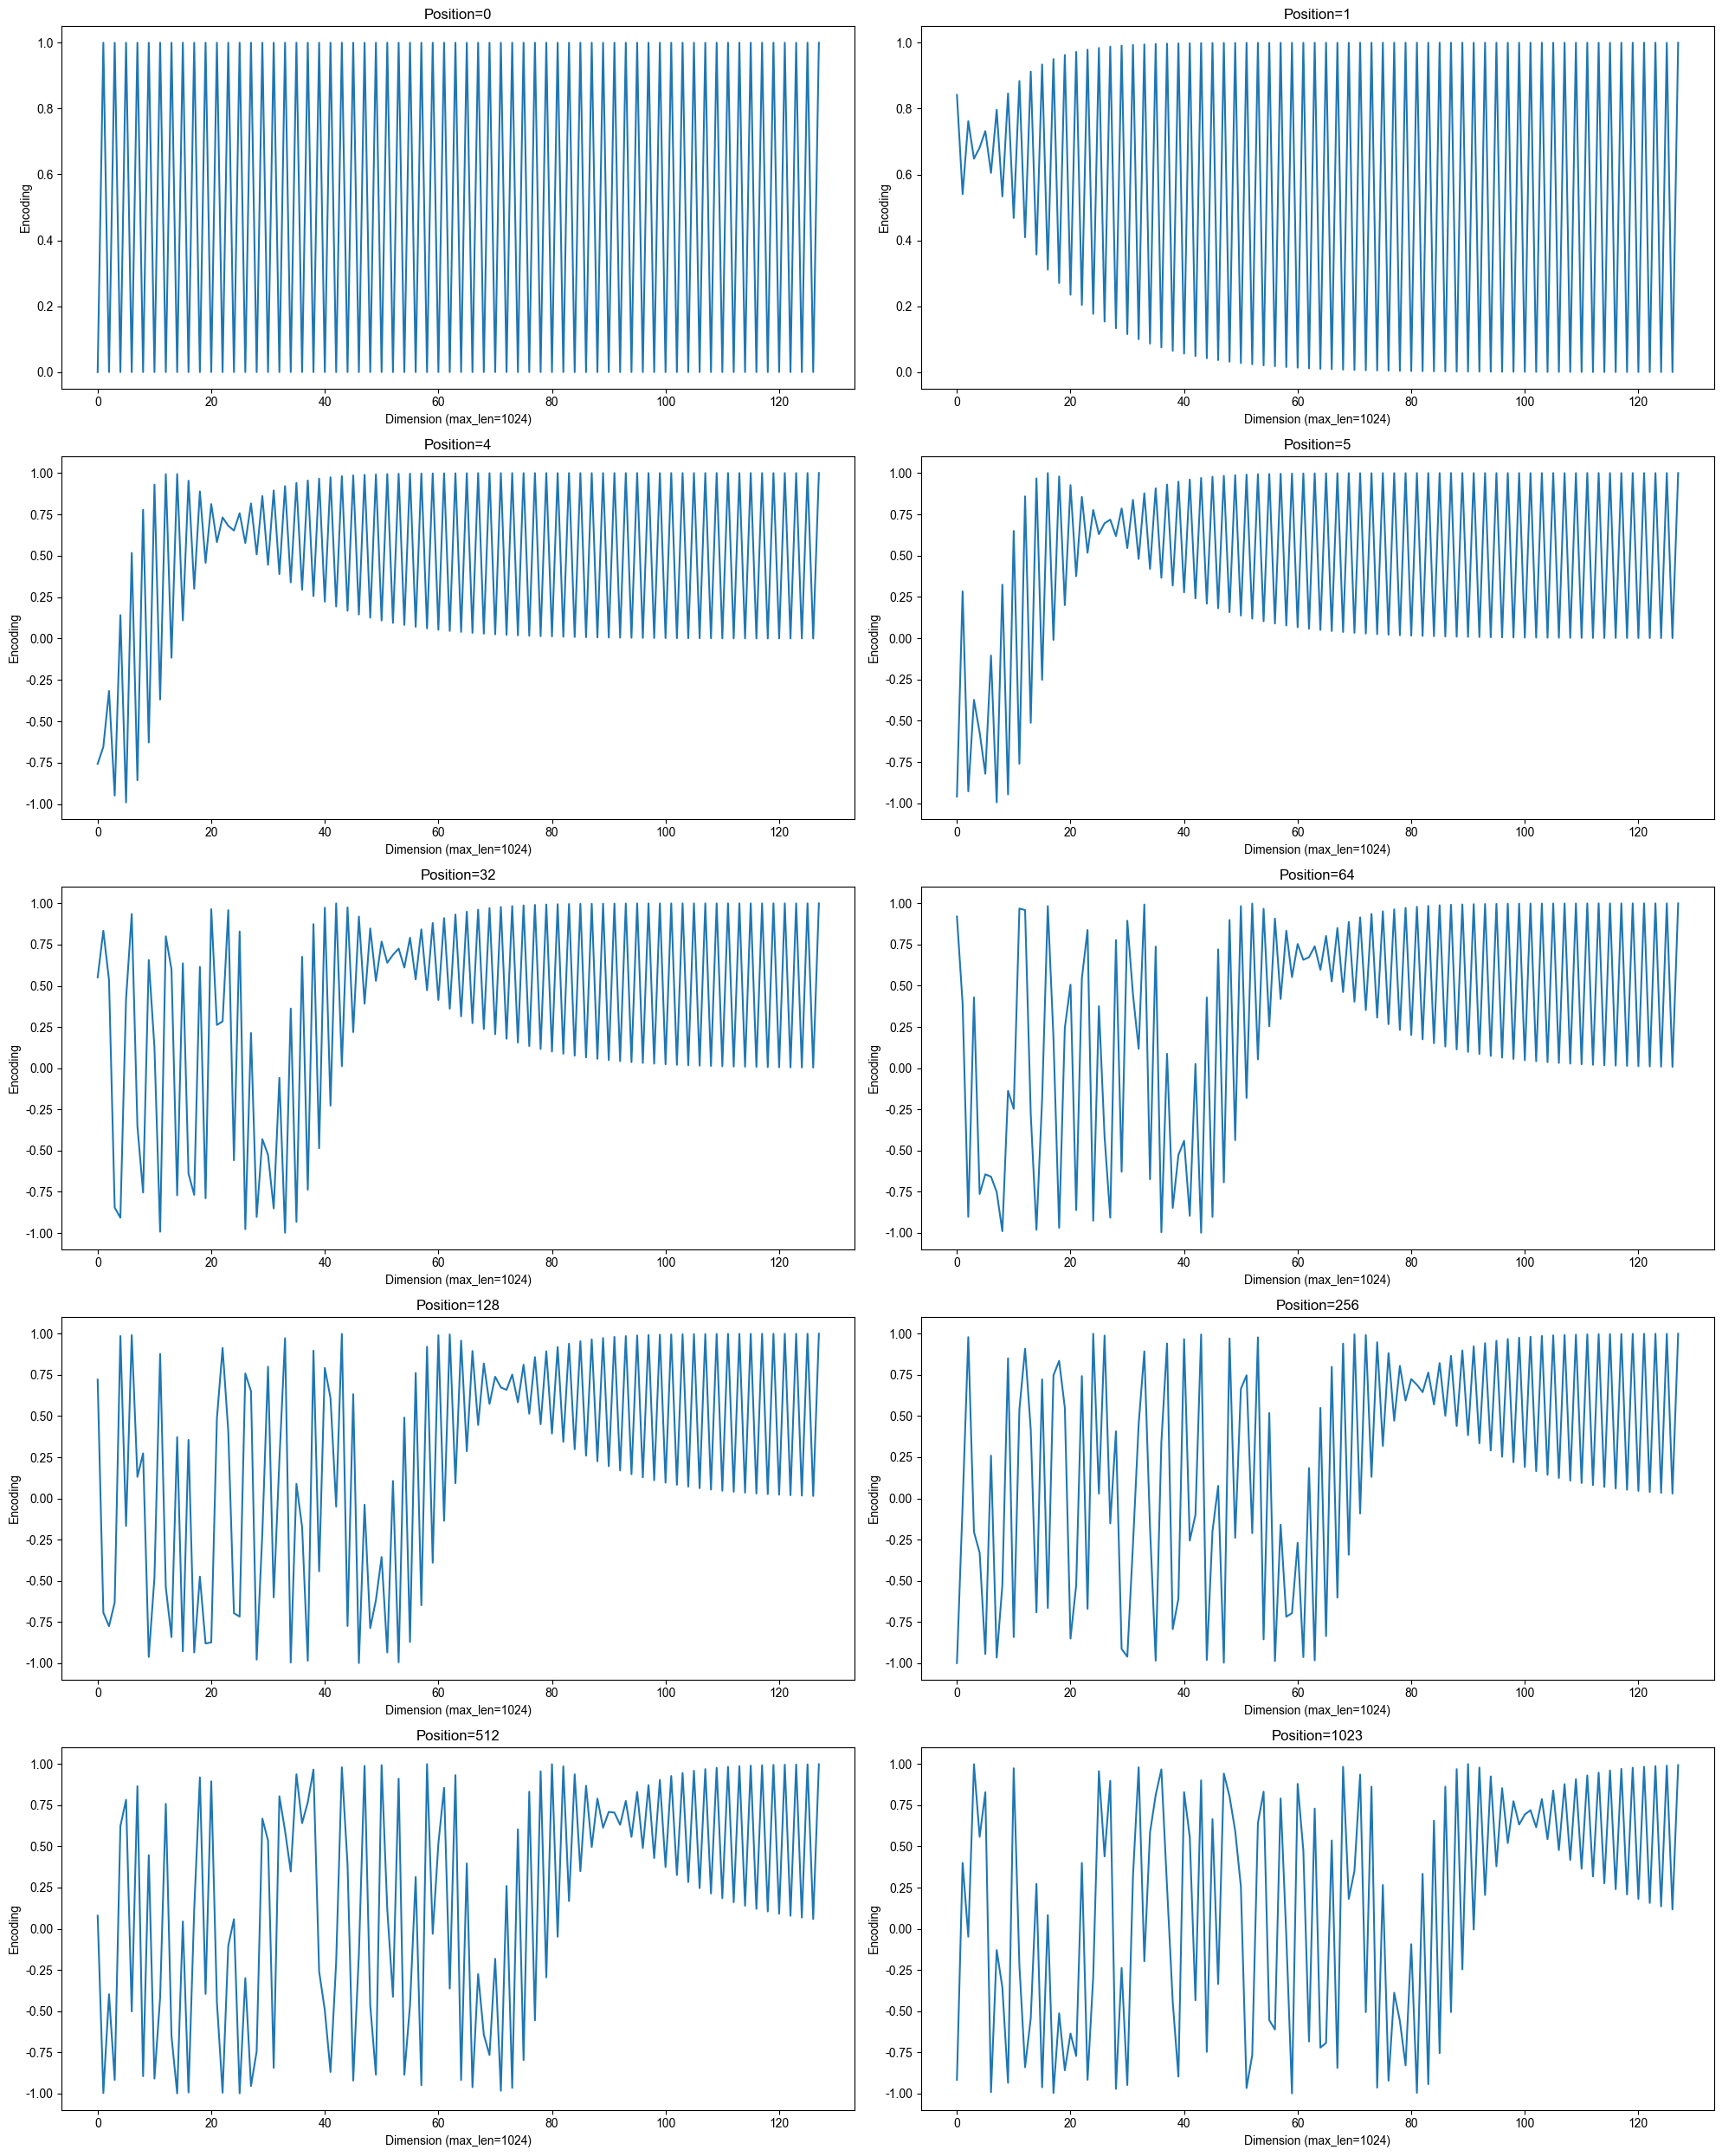

In [123]:
# 位置编码可视化
import matplotlib.pyplot as plt
# 设置matplotlib参数
# 推荐使用的字体（按优先级排序）:
# 1. PingFang SC
# 2. PingFang TC
# 3. STSong
# 4. STKaiti
# 5. STHeiti
# 6. STFangsong
# 7. Hiragino Sans GB
# 8. Arial Unicode MS
# 9. Songti SC
# 10. Kaiti SC
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 设置字体为SimHei, Arial Unicode MS
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分位置可视化，分别可视化0, 32, 64, 96, 128, 256, 512, 1024位置的编码
pos_enc = PositionalEncoding(d_model=128, max_len=1024,)
# 创建5x2的子图布局
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# 遍历位置并在对应子图中绘制
for idx, i in enumerate([0, 1, 4, 5, 32, 64, 128, 256, 512, 1023]):
    axes[idx].plot(pos_enc.encoding.numpy()[i, :])
    axes[idx].set_title(f"Position={i}")
    axes[idx].set_xlabel(f"Dimension (max_len={pos_enc.encoding.shape[0]})")
    axes[idx].set_ylabel("Encoding")

plt.tight_layout()
plt.show()

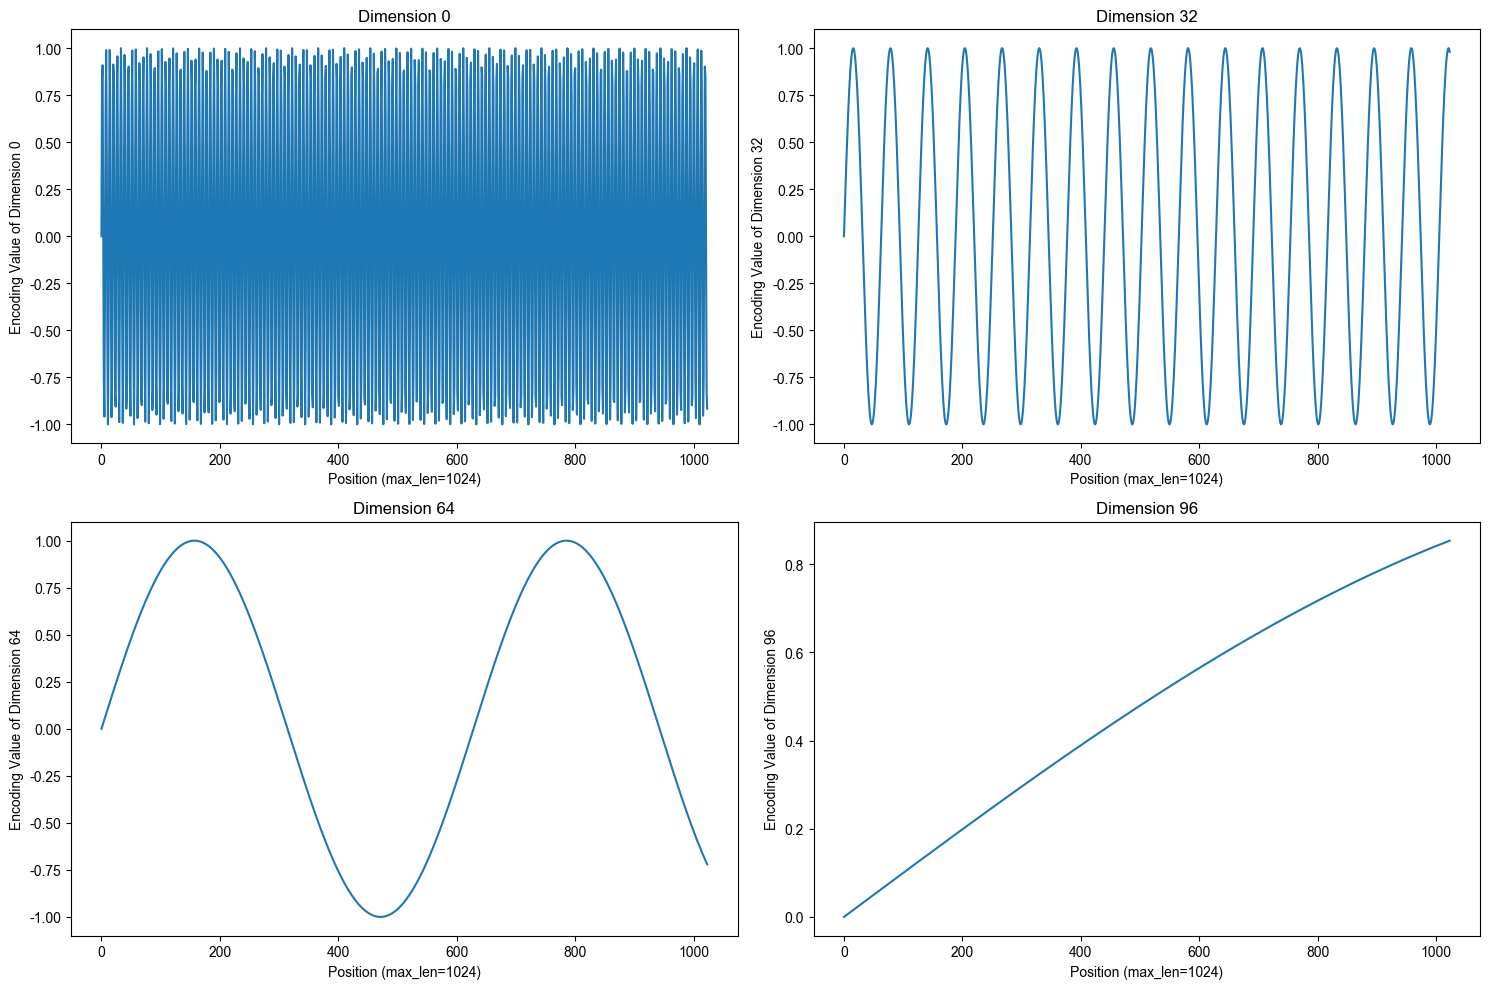

In [124]:
# 分维度可视化,分别可视化0,32,64,96维度的编码
pos_enc = PositionalEncoding(d_model=128, max_len=1024,)
# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# 遍历维度并在对应子图中绘制
for idx, i in enumerate([0, 32, 64, 96]):
    axes[idx].plot(pos_enc.encoding.numpy()[:, i])
    axes[idx].set_title(f"Dimension {i}")
    axes[idx].set_xlabel(f"Position (max_len={pos_enc.encoding.shape[0]})")
    axes[idx].set_ylabel(f"Encoding Value of Dimension {i}")

plt.tight_layout()
plt.show()

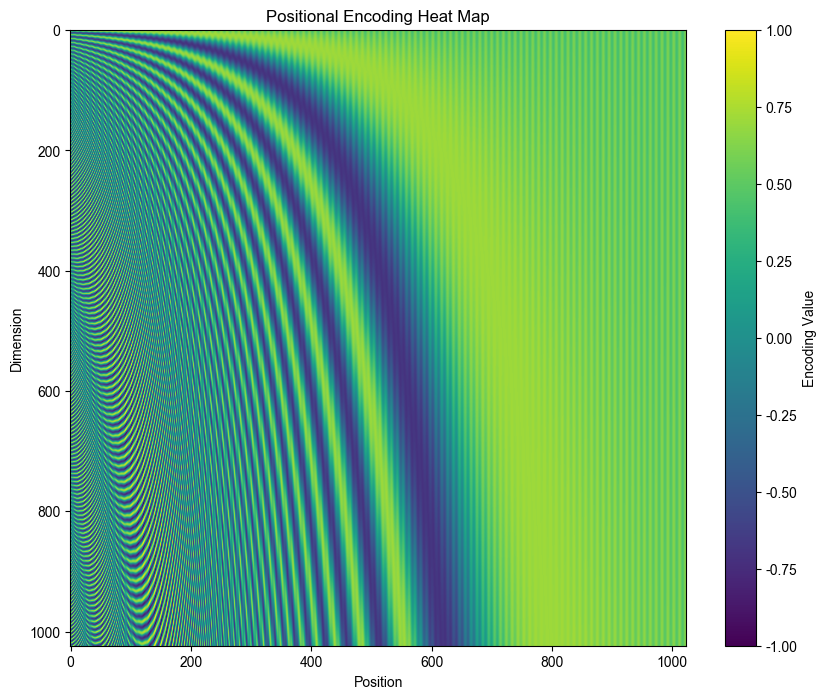

In [125]:
# heat map for positional encoding
import torch
import matplotlib.pyplot as plt

# 创建一个位置编码对象
pos_enc = PositionalEncoding(d_model=1024, max_len=1024)

# 获取位置编码矩阵
encoding = pos_enc.encoding.numpy()

# 创建一个热图
plt.figure(figsize=(10, 8))
plt.imshow(encoding, cmap='viridis')
plt.colorbar(label='Encoding Value')
plt.title('Positional Encoding Heat Map')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.show()

随着位置(pos)的变化
- 让我们以具体数值来理解(以128维为例)：
- 低维度（如维度0,2,4...）：
- 频率较高、周期短：1/10000^(0/128) = 1/1 = 1
- 变化较快，形成短周期波形
- 位置0→32→64→128时，编码值变化缓慢
- 高维度（如维度120,122,124...）：
- 频率很低、周期长：1/10000^(120/128) ≈ 1/6310
- 变化缓慢，形成长周期波形

位置编码的这种多尺度设计是Transformer能够有效处理序列数据
- 位置信息 = 细粒度信息 + 中粒度信息 + 粗粒度信息
- 低维度 → 细粒度：区分近距离位置关系（如相邻词级别） 
- 中维度 → 中粒度：区分中等距离位置关系（如短语级别）  
- 高维度 → 粗粒度：区分远距离位置关系（如句子级别）

相对位置编码：
- 任意两个位置的编码差异包含了它们的相对距离信息
- 模型可以学会通过编码差异来判断词与词之间的距离关系  
两个位置的差异： 
PE(j, 2i) - PE(i, 2i) = sin(j/w) - sin(i/w)  
                       = 2·cos((j+i)/(2w))·sin((j-i)/(2w))                        
其中 w = 10000^(2i/d_model)

## 1.2 词嵌入（Word Embedding）

In [126]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, drop_prob):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        x = self.token_emb(x)
        pos = self.pos_emb(x)
        x = self.dropout(x + pos)
        return x

## 2. 多头注意力机制（Multi-Head Attention）

In [127]:
import math

class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super().__init__()

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.shape

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            # 翻译第一个词时，会mask所有词，因此需要使用-1e9而不是-torch.inf，否则会出现nan
            score.masked_fill_(~mask.bool(), -1e9)

        # 3. pass them softmax to make [0, 1] range
        score = torch.softmax(score, dim=-1)

        # 4. multiply with Value
        v = score @ v

        return v, score

In [128]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.shape

        head_dim = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, head_dim).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.shape
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

## 3. 层归一化（Layer Norm）

In [129]:
# 层归一化是沿着emb维度进行归一化
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # 避免分母为0
        self.eps = 1e-5
        # 每一个emb的维度都有独立的scale和shift
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # 层归一化
        # 一般的输入shape是[batch_size, num_token, emb_dim]
        # 沿着emb维度进行归一化
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # 缩放和平移
        return self.scale * norm_x + self.shift

## 4. 前馈层（Feed Forward）

In [130]:
# 前馈层
class FeedForward(nn.Module):
    def __init__(self, emb_dim, hidden_dim, drop_prob):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim),
            nn.Dropout(drop_prob),
        )

    def forward(self, x):
        return self.layers(x)

## 5. 编码器（Encoder）和解码器（Decoder）

### 5.1 编码器（Encoder）

In [131]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, hidden_dim, num_heads, drop_prob):
        super().__init__()
        # att模块
        self.att = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(drop_prob)

        # ffn模块
        self.ffn = FeedForward(d_model, hidden_dim, drop_prob)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(drop_prob)
    
    def forward(self, x, src_mask):
        # att+shortcut
        shortcut = x
        x = self.att(x, x, x, src_mask)
        x = self.dropout1(x)
        x = self.norm1(x + shortcut)

        # ffn+shortcut
        shortcut = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + shortcut)

        return x
        

In [132]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, max_len, d_model, hidden_dim, num_heads, num_layers, drop_prob):
        super().__init__()
        self.emb = TransformerEmbedding(vocab_size, d_model, max_len, drop_prob)
        self.layers = nn.ModuleList(
            [EncoderLayer(
                d_model,
                hidden_dim,
                num_heads,
                drop_prob
            ) for _ in range(num_layers)]
        )
    
    def forward(self, x, src_mask):
        x = self.emb(x)
        
        for layer in self.layers:
            x = layer(x, src_mask)

        return x


### 5.2 解码器（Decoder）

In [133]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, hidden_dim, num_heads, drop_prob):
        super().__init__()
        # att模块
        self.self_att = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(drop_prob)

        # att模块
        self.cross_att = MultiHeadAttention(d_model, num_heads)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(drop_prob)

        # ffn模块
        self.ffn = FeedForward(d_model, hidden_dim, drop_prob)
        self.norm3 = LayerNorm(d_model)
        self.dropout3 = nn.Dropout(drop_prob)
    
    def forward(self, dec_x, enc_x, trg_mask, src_mask):
        # att+shortcut
        shortcut = dec_x
        x = self.self_att(dec_x, dec_x, dec_x, trg_mask)
        x = self.dropout1(x)
        x = self.norm1(x + shortcut)

        # cross att+shortcut
        if enc_x is not None:
            shortcut = x
            x = self.cross_att(x, enc_x, enc_x, src_mask)
            x = self.dropout2(x)
            x = self.norm2(x + shortcut)

        # ffn+shortcut
        shortcut = x
        x = self.ffn(x)
        x = self.dropout3(x)
        x = self.norm3(x + shortcut)

        return x
    

In [134]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, max_len, d_model, hidden_dim, num_heads, num_layers, drop_prob):
        super().__init__()
        self.emb = TransformerEmbedding(vocab_size, d_model, max_len, drop_prob)
        self.layers = nn.ModuleList(
            [DecoderLayer(
                d_model,
                hidden_dim, 
                num_heads, 
                drop_prob
            ) for _ in range(num_layers)]
        )
        self.out_proj = nn.Linear(d_model, vocab_size)
    
    def forward(self, dec_x, enc_x, trg_mask, src_mask):
        x = self.emb(dec_x)

        for layer in self.layers:
            x = layer(x, enc_x, trg_mask, src_mask)

        x = self.out_proj(x)
        return x


## 6. 完整Transformer模型

In [135]:
class Transformer(nn.Module):
    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, d_model, enc_voc_size, dec_voc_size, max_len, ffn_hidden, n_heads, n_layers, drop_prob):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.encoder = Encoder(
            enc_voc_size, 
            max_len, 
            d_model,
            ffn_hidden, 
            n_heads, 
            n_layers, 
            drop_prob
        )
        self.decoder = Decoder(
            dec_voc_size, 
            max_len, 
            d_model,
            ffn_hidden, 
            n_heads, 
            n_layers, 
            drop_prob
        )
    
    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(tgt)
        enc_x = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_x, trg_mask, src_mask)
        return output

    # 生成源语言的mask
    def make_src_mask(self, src):
        # 创建一个mask，用于屏蔽源语言的pad token
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    # 生成目标语言的mask
    def make_trg_mask(self, tgt):
        # 创建一个mask，用于屏蔽目标语言的pad token
        trg_pad_mask = (tgt != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        # 创建一个mask，用于屏蔽目标语言的subsequent token
        trg_len = tgt.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
